## Homework #8





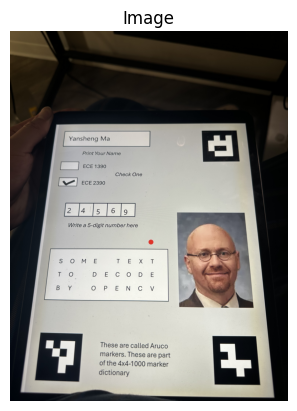

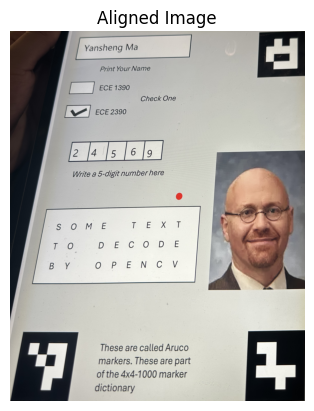

Detected Name: Yansheng Ma
ECE 2390 is checked.
Decoded 5-digit number: 24569
Tesseract Decoded Text Box: S$ OME T EX T

TO DECODE

BY O PEN CV
|


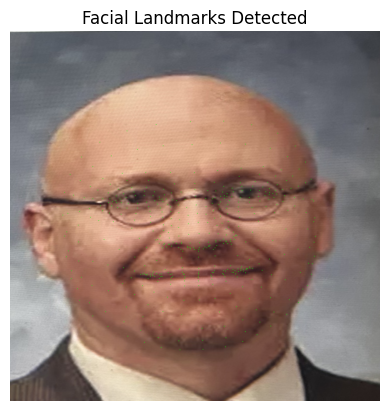

In [1]:
import cv2
import numpy as np
import easyocr
from cv2 import aruco
import mediapipe as mp
import matplotlib.pyplot as plt
import pytesseract

# Load the image
image_path = "4.jpg"
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Image")
plt.axis("off")
plt.show()
if image is None:
    print("Error: Failed to load image.")
    exit()

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
aligned_image = None

# Detect ArUco markers
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_1000)
aruco_params = aruco.DetectorParameters()
corners, ids, rejected = aruco.detectMarkers(gray, aruco_dict, parameters=aruco_params)

if ids is not None:
    detected_corners = {id[0]: corner for id, corner in zip(ids, corners)}

    if len(detected_corners) >= 3:
        selected_ids = [7, 0, 53]
        right_bottom = detected_corners[selected_ids[0]][0][2]
        left_bottom = detected_corners[selected_ids[1]][0][3]
        right_top = detected_corners[selected_ids[2]][0][1]

        left_top_x = right_top[0] + (left_bottom[0] - right_bottom[0])
        left_top_y = right_top[1] + (left_bottom[1] - right_bottom[1])

        target_width, target_height = 2892, 3630
        dst_points = np.array([[0, 0], [target_width - 1, 0], 
                                [target_width - 1, target_height - 1], 
                                [0, target_height - 1]], dtype="float32")
        src_points = np.array([left_bottom, right_bottom, right_top, [left_top_x, left_top_y]], dtype="float32")
        matrix = cv2.getPerspectiveTransform(src_points, dst_points)
        aligned_image = cv2.warpPerspective(image, matrix, (target_width, target_height))
        aligned_image = cv2.rotate(aligned_image, cv2.ROTATE_180)
        aligned_image = cv2.flip(aligned_image, 1)
        plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
        plt.title("Aligned Image")
        plt.axis("off")
        plt.show()
if aligned_image is not None:
    image = aligned_image

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

name_box_coords = [691, 78, 1760, 243]
checkbox_1390_coords = [605, 510, 801, 612]
checkbox_2390_coords = [558, 738, 778, 840]
text_box_coords = [353, 1759, 1815, 2459]
face_picture_coords = [2035, 1186, 2883, 2506]
digit_coords = [
    [605, 1099, 685, 1249],
    [785, 1099, 943, 1349],
    [950, 1099, 1115, 1249],
    [1139, 1099, 1280, 1249],
    [1312, 1099, 1445, 1249]
]

reader = easyocr.Reader(['en'])

# Detect name
name_crop = image[name_box_coords[1]:name_box_coords[3], name_box_coords[0]:name_box_coords[2]]
name_crop_gray = cv2.cvtColor(name_crop, cv2.COLOR_BGR2GRAY)
name_text = reader.readtext(name_crop_gray)
print("Detected Name:", name_text[0][1] if name_text else "Name not detected.")

# Detect checkboxes
checkbox_1390 = np.mean(image[checkbox_1390_coords[1]:checkbox_1390_coords[3], checkbox_1390_coords[0]:checkbox_1390_coords[2]])
checkbox_2390 = np.mean(image[checkbox_2390_coords[1]:checkbox_2390_coords[3], checkbox_2390_coords[0]:checkbox_2390_coords[2]])
print("ECE 2390 is checked." if checkbox_2390 < checkbox_1390 else "ECE 1390 is checked.")

# Detect digits
digits = []
for coord in digit_coords:
    x1, y1, x2, y2 = coord
    digit_crop = image[y1:y2, x1:x2]
    digit_gray = cv2.cvtColor(digit_crop, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    digit_enhanced = clahe.apply(digit_gray)
    _, digit_thresh = cv2.threshold(digit_enhanced, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    digit_text = reader.readtext(digit_thresh, allowlist="0123456789")
    digits.append(digit_text[0][1] if digit_text else '?')
print("Decoded 5-digit number:", ''.join(digits))

# Detect text box
text_box_crop = image[text_box_coords[1]:text_box_coords[3], text_box_coords[0]:text_box_coords[2]]
text_box_gray = cv2.cvtColor(text_box_crop, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
text_box_enhanced = clahe.apply(text_box_gray)
_, text_box_thresh = cv2.threshold(text_box_enhanced, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
custom_config = r'--psm 6'
tesseract_text = pytesseract.image_to_string(text_box_thresh, config=custom_config)
print("Tesseract Decoded Text Box:", tesseract_text.strip())

# Detect facial features
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)
face_crop = image[face_picture_coords[1]:face_picture_coords[3], face_picture_coords[0]:face_picture_coords[2]]
face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
h, w = face_rgb.shape[:2]
size = max(h, w)
face_resized = cv2.resize(face_rgb, (size, size))
results = face_mesh.process(face_resized)

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        for landmark in face_landmarks.landmark:
            x, y = int(landmark.x * size), int(landmark.y * size)
            cv2.circle(face_resized, (x, y), 1, (0, 255, 0), -1)
    plt.imshow(face_resized)
    plt.title("Facial Landmarks Detected")
    plt.axis("off")
    plt.show()
else:
    print("No facial landmarks detected.")
